In [1]:
import glob, os, sys
import uproot, ROOT
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, roc_auc_score, auc
sys.path.append("..")
from utils.utils import *

Welcome to JupyROOT 6.28/04


In [6]:
branches = ['mcEventNumber',
            'ditau_subjet_pt',
            'ditau_BDTScore',
            'ditau_BDTScoreNew',
            'ditau_ditau_pt',
            'ditau_n_subjets',
            'mcEventWeights',
            'ditau_IsTruthHadronic',
            'ditau_n_tracks_lead',
            'ditau_n_tracks_subl',
            'ditau_R_max_lead', 'ditau_R_max_subl',
            'ditau_R_tracks_subl', 'ditau_R_isotrack', 
            'ditau_d0_leadtrack_lead', 'ditau_d0_leadtrack_subl',
            'ditau_f_core_lead', 'ditau_f_core_subl', 'ditau_f_subjet_subl',
            'ditau_f_subjets', 'ditau_f_isotracks', 
            'ditau_m_core_lead', 'ditau_m_core_subl', 
            'ditau_m_tracks_lead', 'ditau_m_tracks_subl', 'ditau_n_track', 'averageInteractionsPerCrossing', 'ditau_eta']

file_paths = ["/global/cfs/cdirs/atlas/projecta/atlas/atlaslocalgroupdisk/rucio/user/agarabag/44/8e/user.agarabag.37449714._000150.ntuple.root",
              "/global/cfs/cdirs/atlas/projecta/atlas/atlaslocalgroupdisk/rucio/user/agarabag/19/d6/user.agarabag.37404080._000019.ntuple.root"]

# Function to process a single file
def process_file(file_path):
    ditau_BDTScore = []
    ditau_subjet_pt = []

    f_1 = uproot.open(file_path + ':CollectionTree')

    # Load arrays for non-nested branches
    non_nested_branches = [b for b in branches if b != 'ditau_subjet_pt']
    events_non_nested = f_1.arrays(non_nested_branches, library='ak')

    flatten_ditau_BDTScore = ak.flatten(events_non_nested['ditau_BDTScore'])
    ditau_BDTScore.append(flatten_ditau_BDTScore.tolist())

    # Load nested branch in chunks to handle possible issues
    try:
        events_nested = f_1.arrays(['ditau_subjet_pt'], library='ak', entry_stop=10000)
        for pt_list in events_nested['ditau_subjet_pt']:
            flat_pt_list = ak.flatten(pt_list)
            if len(flat_pt_list) > 3:
                ditau_subjet_pt.append([0])
            else:
                ditau_subjet_pt.append(flat_pt_list.tolist())
    except Exception as e:
        print(f"Error reading ditau_subjet_pt in file {file_path}: {e}")
        return ditau_BDTScore, []

    return ditau_BDTScore, ditau_subjet_pt

# Initialize lists to hold data from all files
all_ditau_BDTScore = []
all_ditau_subjet_pt = []

# Process each file separately and combine results
for file_path in file_paths:
    ditau_BDTScore, ditau_subjet_pt = process_file(file_path)
    all_ditau_BDTScore.extend(ditau_BDTScore)
    all_ditau_subjet_pt.extend(ditau_subjet_pt)

# Combine BDTScore into a single numpy array
data_ditau_BDTScore = ak.to_numpy(ak.concatenate(all_ditau_BDTScore))
# data_ditau_subjet_pt = ak.concatenate(all_ditau_subjet_pt, axis=0)

print("BDTScore: ", data_ditau_BDTScore)
# print("Subjet PT: ", all_ditau_subjet_pt)
# print("Subjet PT: ", data_ditau_subjet_pt)



BDTScore:  [0.35982922 0.31217077 0.61887515 ... 0.25732702 0.31351292 0.39392763]
Subjet PT:  [[319248.5], [], [], [], [], [], [175934.234375, 46510.96484375, 21601.728515625], [], [], [], [], [22381.9921875], [], [0], [], [0], [], [291468.40625, 43317.5078125, 290467.4375], [0], [0], [], [], [], [], [], [0], [], [], [198688.203125, 18041.130859375], [], [], [274622.1875], [], [0], [], [0], [0], [], [0], [], [], [], [264104.6875, 11585.1611328125], [], [0], [0], [0], [], [], [274677.3125, 268803.8125], [], [0], [], [265167.0], [], [], [232819.53125], [], [], [0], [], [], [], [298689.1875], [], [396953.5625, 335905.9375, 44972.41796875], [221428.171875, 14575.693359375], [0], [0], [], [], [253684.1875], [], [], [], [], [], [], [], [182446.3125, 45339.06640625], [0], [216543.46875, 28005.802734375], [0], [0], [285892.96875, 14037.9501953125, 12608.3369140625], [238157.9375], [], [261874.484375, 22963.6875], [], [0], [], [0], [], [0], [261173.359375], [], [], [295410.71875, 13750.8056640

In [13]:
type(all_ditau_subjet_pt)

list

In [2]:
def signal_cut(df_chunk):
    cut1 = (df_chunk['IsTruthHadronic']==1)
    cut2 = (df_chunk['n_subjets'] >=2)
    cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut3 & cut4)
    
def bkg_cut(df_chunk):
    cut1 = (df_chunk['n_subjets'] >=2)
    cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut3)

def h52panda(filelist, xs, cut, bkg=0):
    combined = pd.DataFrame()
    chunk_size = 10000000  # Adjust this size to suit your system's memory
    pt_bins = np.linspace(200000, 1000000, 41)

    dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
                "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
                "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
                "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
                "d0_leadtrack_lead", "d0_leadtrack_subl",
                "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
                "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta"]

    for index in range(len(filelist)):
        file_path = filelist[index]
    
        # Process the file in chunks
        with h5py.File(file_path, 'r') as h5_file:
            # Determine the total length of the datasets
            total_length = h5_file[dataset_keys[0]].shape[0]
            print(f'{filelist[index]}: {total_length}')

            # Read and process each chunk
            for chunk_start in range(0, total_length, chunk_size):
                chunk_end = chunk_start + chunk_size

                # Use slicing to read a chunk from each dataset in the HDF5 file
                data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

                # Convert the dictionary to a pandas DataFrame
                df_chunk = pd.DataFrame(data)

                # Apply Cut
                filtered_chunk = df_chunk[cut(df_chunk)]
                filtered_chunk = filtered_chunk.copy()
                filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

                combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
    combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
    combined['label'] = bkg
    combined['weight'] = combined['event_weight'] * combined['pT_weight']

    return combined

path = "/global/u2/a/agarabag/pscratch/ditdau_samples/"

bkg_xs = [364701, 364702, 364703, 364704, 364705, 364706, 364707, 364708, 364709, 364710, 364711, 364712]
signal_xs = [425108, 425100, 425101, 425102, 425103, 425104, 425105, 425106, 425107, 425200]
# gamma_xs = [425200]

# File Location. order maatch XS. 
bkg_filelist = []
for index in range(12):
    bkg_filelist.append(path+f"jz_w_newbdt/dijet_flattened_jz{index+1}.h5")

signal_filelist = [path+"signal_w_newbdt/graviton_flattened_M1000.h5",
                path+"signal_w_newbdt/graviton_flattened_M1500.h5",
                path+"signal_w_newbdt/graviton_flattened_M1750.h5",
                path+"signal_w_newbdt/graviton_flattened_M2000.h5",
                path+"signal_w_newbdt/graviton_flattened_M2250.h5",
                path+"signal_w_newbdt/graviton_flattened_M2500.h5",
                path+"signal_w_newbdt/graviton_flattened_M3000.h5",
                path+"signal_w_newbdt/graviton_flattened_M4000.h5",
                path+"signal_w_newbdt/graviton_flattened_M5000.h5",
                path+"signal_w_newbdt/gamma_flattened_0.h5"]

# combined_signal = h52panda(signal_filelist, signal_xs, signal_cut, 1)
# combined_bkg = h52panda(bkg_filelist, bkg_xs, bkg_cut, 0)

comb_vh_signal = h52panda([path+"VHtautau_ntuple_flattened.h5"], [802168], signal_cut, 1)

/global/u2/a/agarabag/pscratch/ditdau_samples/VHtautau_ntuple_flattened.h5: 15997642


In [3]:
print(getXS(802168))

0.00029714065111


In [7]:
combined_bkg.to_csv(path+'combined_bkg_inc_2.csv', index=False)
combined_signal.to_csv(path+'combined_signal_inc_2.csv', index=False)

In [4]:
comb_vh_signal.to_csv(path+'vhtautau_ntuple_inc.csv', index=False)

In [41]:
combined_signal.describe()

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,average_mu,eta,pT_weight,label,weight
count,2.931560e+05,293156.000000,293156.0,293156.000000,293156.000000,293156.000000,293156.000000,293156.000000,293156.000000,293156.000000,...,293156.000000,293156.000000,2.931560e+05,293156.000000,293156.000000,293156.000000,293156.000000,293156.000000,293156.0,2.931560e+05
mean,3.218403e+05,591016.716361,1.0,0.904727,0.817445,0.215223,0.889530,0.005232,0.017571,0.026478,...,1.525631,2.245125,2.814038e-08,0.744169,0.934390,37.324991,0.003000,22920.684644,1.0,1.366069e-04
std,1.496888e+06,190998.220076,0.0,0.087722,0.150057,0.122129,0.064235,0.014082,0.028280,0.030772,...,0.880328,0.624256,5.622011e-08,0.046110,0.152584,12.997303,0.702942,34725.975668,0.0,3.941051e-04
min,3.000000e+00,200011.550000,1.0,0.004786,0.002572,0.009276,0.212556,0.000000,0.000033,0.000006,...,1.000000,2.000000,2.979492e-12,0.338990,0.001220,0.500000,-2.469175,1421.856802,1.0,4.236410e-09
25%,2.180215e+05,435873.900000,1.0,0.884087,0.773695,0.109713,0.859695,0.000000,0.006127,0.009973,...,1.000000,2.000000,1.243500e-09,0.720537,0.958889,27.500000,-0.490863,2565.403226,1.0,1.679851e-05
50%,2.786110e+05,583112.800000,1.0,0.927470,0.860856,0.206020,0.903453,0.002653,0.010370,0.017066,...,1.000000,2.000000,2.796000e-09,0.749271,0.988325,35.500000,0.005973,9030.211588,1.0,5.121672e-05
75%,3.396830e+05,736069.750000,1.0,0.957042,0.915617,0.314963,0.934730,0.006941,0.017368,0.029548,...,3.000000,2.000000,1.743939e-08,0.776611,0.994809,45.500000,0.499521,24652.550201,1.0,1.574814e-04
max,4.512877e+07,999981.560000,1.0,0.998689,1.000000,0.514636,1.059908,5.513919,0.200000,0.200000,...,3.000000,10.000000,1.684950e-07,0.827959,0.996925,90.500000,2.493145,183608.383037,1.0,3.093709e-02


In [20]:
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/"
combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
combined_signal = pd.read_csv(path+'inc_bdt_signal.csv')

In [21]:
signal_scores = combined_signal['bdt_score']
print(np.sum(signal_scores > 0.72) / len(signal_scores))

0.7532474177570986


In [22]:
signal_scores = combined_signal['bdt_score_new']
print(np.sum(signal_scores > 0.957) / len(signal_scores))

0.7564914243610911


In [12]:
signal_scores = combined_signal['bdt_score_new']
print(np.sum(signal_scores > 0.986) / len(signal_scores))

0.5449044194899644


In [13]:
bkg = combined_bkg['bdt_score_new']
print(np.sum(bkg > 0.01) / len(bkg))

0.5521729938552566


In [5]:
bkg = combined_bkg['bdt_score']
print(np.sum(bkg > 0.55) / len(bkg))

0.2534350073811213


In [18]:
signal_scores = combined_signal['inc_new_bdt'][combined_signal['inc_new_bdt'] > 0]
print(np.sum(signal_scores > 0.957) / len(signal_scores))

0.7279085574271217


In [19]:
bkg = combined_bkg['inc_new_bdt'][combined_bkg['inc_new_bdt'] > 0]
print(np.sum(bkg > 0.045) / len(bkg))

0.25100196644043676


In [38]:
len(combined_bkg), len(combined_signal)

(2180563, 293156)

In [5]:
len(pd.read_csv(path+'combined_bkg_inc_new.csv'))


2180563

In [23]:
import pandas as pd

class DataFrameCuts:
    def __init__(self, df_bkg, df_signal):
        self.df_bkg = df_bkg
        self.df_signal = df_signal

    def apply_cut(self, df, cut_condition):
        return df[cut_condition]

    def cut4(self, df):
        return self.apply_cut(df, ((df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 3)) | ((df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 1)))

    def cut5(self, df):
        return self.apply_cut(df, (df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 1))

    def cut6(self, df):
        return self.apply_cut(df, (df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 3))

    def cut7(self, df):
        return self.apply_cut(df, ((df['n_tracks_lead'] == 1) | (df['n_tracks_lead'] == 3)) & ((df['n_tracks_subl'] == 1) | (df['n_tracks_subl'] == 3)))

    def process(self):
        self.combined_bkg_1p3p = self.cut4(self.df_bkg)
        self.combined_bkg_1p1p = self.cut5(self.df_bkg)
        self.combined_bkg_3p3p = self.cut6(self.df_bkg)

        self.combined_signal_1p3p = self.cut4(self.df_signal)
        self.combined_signal_1p1p = self.cut5(self.df_signal)
        self.combined_signal_3p3p = self.cut6(self.df_signal)


        return {
            'bkg': {
                '1p3p': self.combined_bkg_1p3p,
                '1p1p': self.combined_bkg_1p1p,
                '3p3p': self.combined_bkg_3p3p,
                'inc': self.df_bkg
            },
            'signal': {
                '1p3p': self.combined_signal_1p3p,
                '1p1p': self.combined_signal_1p1p,
                '3p3p': self.combined_signal_3p3p,
                'inc': self.df_signal
            }
        }

In [24]:
combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
combined_signal = pd.read_csv(path+'inc_bdt_vhtautau.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.72]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

# Accessing the results
combined_bkg_1p3p = combined['bkg']['1p3p']
combined_bkg_1p1p = combined['bkg']['1p1p']
combined_bkg_3p3p = combined['bkg']['3p3p']
combined_bkg_inc = combined['bkg']['inc']
combined_signal_1p3p = combined['bkg']['1p3p']
combined_signal_1p1p = combined['bkg']['1p1p']
combined_signal_3p3p = combined['bkg']['3p3p']
combined_signal_inc = combined['bkg']['inc']

combined_bkg_1p3p_bdt = combined_bdt['bkg']['1p3p']
combined_bkg_1p1p_bdt = combined_bdt['bkg']['1p1p']
combined_bkg_3p3p_bdt = combined_bdt['bkg']['3p3p']
combined_bkg_inc_bdt = combined_bdt['bkg']['inc']
combined_signal_1p3p_bdt = combined_bdt['bkg']['1p3p']
combined_signal_1p1p_bdt = combined_bdt['bkg']['1p1p']
combined_signal_3p3p_bdt = combined_bdt['bkg']['3p3p']
combined_signal_inc_bdt = combined_bdt['bkg']['inc']



In [27]:
combined

{'bkg': {'1p3p':          event_id   ditau_pt  IsTruthHadronic  f_core_lead  f_core_subl  \
  0        36079784  289045.94                0     0.894528     0.246616   
  3        35893734  248336.08                0     0.680812     0.653458   
  6        26917460  221883.73                0     0.882286     0.677054   
  9        32924154  208441.89                0     0.842463     0.460940   
  11       30846038  204277.62                0     0.904852     0.615187   
  ...           ...        ...              ...          ...          ...   
  2180550   1082150  252817.34                0     0.726470     0.277918   
  2180555   1284683  253029.23                0     0.669082     0.294558   
  2180557   1489518  298590.72                0     0.768915     0.246262   
  2180559   1110524  325928.28                0     0.757148     0.080900   
  2180561   1033696  290693.70                0     0.959796     0.055276   
  
           f_subjet_subl  f_subjets  f_isotracks  R_max_le

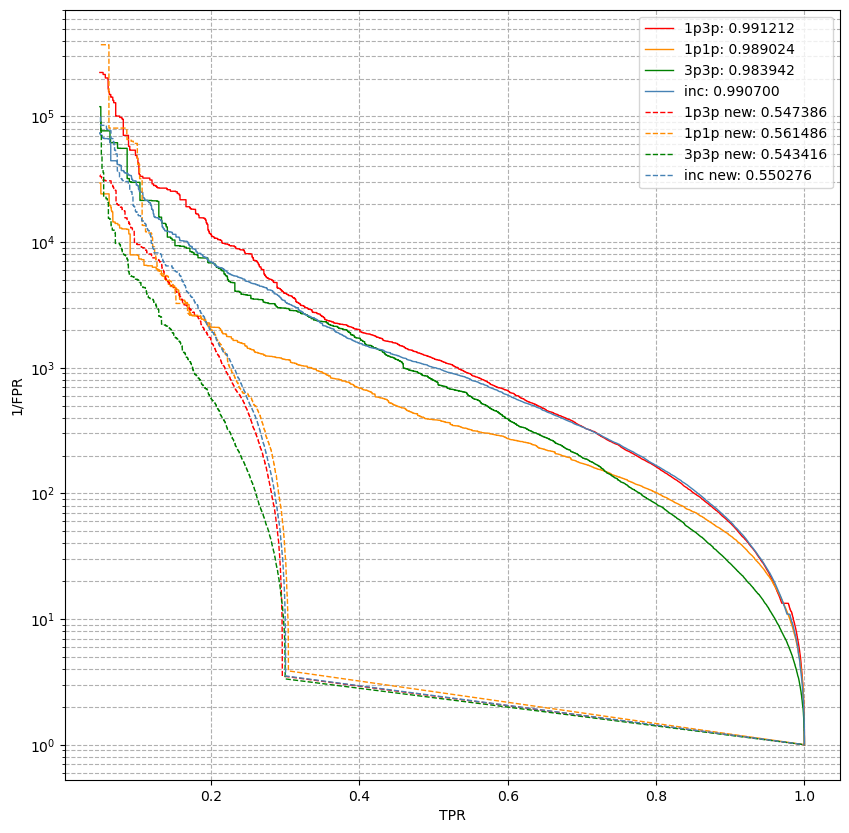

In [26]:
channel = ['1p3p', '1p1p', '3p3p', 'inc']
color = ['red', 'darkorange', 'green', 'steelblue']

fig7 = plt.figure(figsize=(10, 10))
for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score'], combined['bkg'][channel[i]]['bdt_score'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f'{channel[i]}: {roc_auc:.6f}')

for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['inc_new_bdt'], combined['bkg'][channel[i]]['inc_new_bdt'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], linestyle='dashed', label=f'{channel[i]} new: {roc_auc:.6f}')
             
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [8]:
''' Testing for Testing Data
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

def tmp(df):
    df['eventID_mod'] = df['event_id'] % 10
    train_df = df[df['eventID_mod'] < 7] # 70%
    test_df = df[df['eventID_mod'] >= 7] # 30%
    return test_df

combined_signal = tmp(combined_signal)
combined_bkg = tmp(combined_bkg)

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

channel = ['1p3p', '1p1p', '3p3p', 'inc']
color = ['red', 'darkorange', 'green', 'steelblue']

fig7 = plt.figure(figsize=(10, 10))
for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score'], combined['bkg'][channel[i]]['bdt_score'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f'{channel[i]}: {roc_auc:.6f}')

for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score_new'], combined['bkg'][channel[i]]['bdt_score_new'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], linestyle='dashed', label=f'{channel[i]} new: {roc_auc:.6f}')
             
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
'''

' Testing for Testing Data\ncombined_bkg = pd.read_csv(path+\'combined_bkg_inc.csv\')\ncombined_signal = pd.read_csv(path+\'combined_signal_inc.csv\')\n\ndef tmp(df):\n    df[\'eventID_mod\'] = df[\'event_id\'] % 10\n    train_df = df[df[\'eventID_mod\'] < 7] # 70%\n    test_df = df[df[\'eventID_mod\'] >= 7] # 30%\n    return test_df\n\ncombined_signal = tmp(combined_signal)\ncombined_bkg = tmp(combined_bkg)\n\ncuts_processor = DataFrameCuts(combined_bkg, combined_signal)\ncombined = cuts_processor.process()\n\nchannel = [\'1p3p\', \'1p1p\', \'3p3p\', \'inc\']\ncolor = [\'red\', \'darkorange\', \'green\', \'steelblue\']\n\nfig7 = plt.figure(figsize=(10, 10))\nfor i in range(4):\n    fpr, tpr = calc_roc(combined[\'signal\'][channel[i]][\'bdt_score\'], combined[\'bkg\'][channel[i]][\'bdt_score\'], combined[\'signal\'][channel[i]][\'weight\'], combined[\'bkg\'][channel[i]][\'weight\'])\n    roc_auc = auc(fpr, tpr)\n    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f\'{channel[i]

In [49]:
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.96]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

%jsroot on
ROOT.gStyle.SetOptStat(0)
ROOT.gROOT.SetBatch(True)
canvas = ROOT.TCanvas("canvas", "eff_plots", 800, 500)
# canvas.cd()
# canvas.Print("eff_plots.pdf[")

class DataList:
    def __init__(self, combined, combined_bdt):
        self.combined = combined
        self.combined_bdt = combined_bdt
        self.categories = ['1p3p', '1p1p', '3p3p', 'inc']

    def create_list(self, sig_bkg, variable):
        data_list = []
        for category in self.categories:
            data_list.append(self.combined[sig_bkg][category][variable])
            data_list.append(self.combined_bdt[sig_bkg][category][variable])
        return data_list
    
data_list = DataList(combined, combined_bdt)

sig_pt_list = data_list.create_list('signal', 'ditau_pt')
sig_eta_list = data_list.create_list('signal', 'eta')
sig_mu_list = data_list.create_list('signal', 'average_mu')
sig_w_list = data_list.create_list('signal', 'event_weight')
bkg_pt_list = data_list.create_list('bkg', 'ditau_pt')
bkg_eta_list = data_list.create_list('bkg', 'eta')
bkg_mu_list = data_list.create_list('bkg', 'average_mu')
bkg_w_list = data_list.create_list('bkg', 'event_weight')

pt_1p3p_eff_w, pt_1p1p_eff_w, pt_3p3p_eff_w, pt_inc_eff_w = plot_eff(bkg_pt_list, bkg_w_list, "DiJet pT", 20, 200000, 1000000, eta=False)
pt_1p3p_eff_w.SetMarkerStyle(22)
pt_1p1p_eff_w.SetMarkerStyle(22)
pt_3p3p_eff_w.SetMarkerStyle(22)
pt_inc_eff_w.SetMarkerStyle(22)
pt_1p3p_eff_w.Draw(" e")
pt_1p1p_eff_w.Draw("same e")
pt_3p3p_eff_w.Draw("same e")
pt_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(pt_1p3p_eff_w, "1p3p w")
legend.AddEntry(pt_1p1p_eff_w, "1p1p w")
legend.AddEntry(pt_3p3p_eff_w, "3p3p w")
legend.AddEntry(pt_inc_eff_w, "inclusive w")
legend.Draw()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [50]:
eta_1p3p_eff_w, eta_1p1p_eff_w, eta_3p3p_eff_w, eta_inc_eff_w = plot_eff(bkg_eta_list, bkg_w_list, "DiJet eta", 40, -2.5, 2.5, eta=True)
eta_1p3p_eff_w.SetMarkerStyle(22)
eta_1p1p_eff_w.SetMarkerStyle(22)
eta_3p3p_eff_w.SetMarkerStyle(22)
eta_inc_eff_w.SetMarkerStyle(22)
eta_1p3p_eff_w.Draw(" e")
eta_1p1p_eff_w.Draw("same e")
eta_3p3p_eff_w.Draw("same e")
eta_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(eta_1p3p_eff_w, "1p3p")
legend.AddEntry(eta_1p1p_eff_w, "1p1p")
legend.AddEntry(eta_3p3p_eff_w, "3p3p")
legend.AddEntry(eta_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [51]:
eta_inc_eff_w.SetMarkerStyle(22)
eta_inc_eff_w.SetLineColor(ROOT.kBlue)
eta_inc_eff_w.Draw(" e")
legend = ROOT.TLegend(0.7, 0.8, 0.85, 0.9)
legend.AddEntry(eta_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

In [52]:
mu_1p3p_eff_w, mu_1p1p_eff_w, mu_3p3p_eff_w, mu_inc_eff_w = plot_eff(bkg_mu_list, bkg_w_list, "DiJet mu", 20, 18, 74, eta=False)
mu_1p3p_eff_w.SetMarkerStyle(22)
mu_1p1p_eff_w.SetMarkerStyle(22)
mu_3p3p_eff_w.SetMarkerStyle(22)
mu_inc_eff_w.SetMarkerStyle(22)
mu_1p3p_eff_w.Draw(" e")
mu_1p1p_eff_w.Draw("same e")
mu_3p3p_eff_w.Draw("same e")
mu_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(mu_1p3p_eff_w, "1p3p")
legend.AddEntry(mu_1p1p_eff_w, "1p1p")
legend.AddEntry(mu_3p3p_eff_w, "3p3p")
legend.AddEntry(mu_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [53]:
mu_inc_eff_w.SetMarkerStyle(22)
mu_inc_eff_w.SetLineColor(ROOT.kBlue)
mu_inc_eff_w.Draw(" e")
legend = ROOT.TLegend(0.7, 0.7, 0.85, 0.85)
legend.AddEntry(mu_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()


In [54]:
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.96]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

class DataList:
    def __init__(self, combined, combined_bdt):
        self.combined = combined
        self.combined_bdt = combined_bdt
        self.categories = ['1p3p', '1p1p', '3p3p', 'inc']

    def create_list(self, sig_bkg, variable):
        data_list = []
        for category in self.categories:
            data_list.append(self.combined[sig_bkg][category][variable])
            data_list.append(self.combined_bdt[sig_bkg][category][variable])
        return data_list
    
data_list = DataList(combined, combined_bdt)

sig_pt_list = data_list.create_list('signal', 'ditau_pt')
sig_eta_list = data_list.create_list('signal', 'eta')
sig_mu_list = data_list.create_list('signal', 'average_mu')
sig_w_list = data_list.create_list('signal', 'event_weight')
bkg_pt_list = data_list.create_list('bkg', 'ditau_pt')
bkg_eta_list = data_list.create_list('bkg', 'eta')
bkg_mu_list = data_list.create_list('bkg', 'average_mu')
bkg_w_list = data_list.create_list('bkg', 'event_weight')

In [55]:
pt_sig_1p3p_eff_w, pt_sig_1p1p_eff_w, pt_sig_3p3p_eff_w, pt_sig_inc_eff_w = plot_eff(sig_pt_list, sig_w_list, "Signal pT", 20, 200000, 1000000, eta=False)
pt_sig_1p3p_eff_w.SetMarkerStyle(22)
pt_sig_1p1p_eff_w.SetMarkerStyle(22)
pt_sig_3p3p_eff_w.SetMarkerStyle(22)
pt_sig_inc_eff_w.SetMarkerStyle(22)
pt_sig_1p3p_eff_w.Draw(" e")
pt_sig_1p1p_eff_w.Draw("same e")
pt_sig_3p3p_eff_w.Draw("same e")
pt_sig_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(pt_sig_1p3p_eff_w, "1p3p w")
legend.AddEntry(pt_sig_1p1p_eff_w, "1p1p w")
legend.AddEntry(pt_sig_3p3p_eff_w, "3p3p w")
legend.AddEntry(pt_sig_inc_eff_w, "inclusive w")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
